[[ 96. -12.   0. -12. -12.   0.   0.   0.   0.]
 [-12.  96. -12. -12. -12. -12.   0.   0.   0.]
 [  0. -12.  96.   0. -12. -12.   0.   0.   0.]
 [-12. -12.   0.  96. -12.   0. -12. -12.   0.]
 [-12. -12. -12. -12.  96. -12. -12. -12. -12.]
 [  0. -12. -12.   0. -12.  96.   0. -12. -12.]
 [  0.   0.   0. -12. -12.   0.  96. -12.   0.]
 [  0.   0.   0. -12. -12. -12. -12.  96. -12.]
 [  0.   0.   0.   0. -12. -12.   0. -12.  96.]]
[[1.     0.25   0.     0.25   0.0625 0.     0.     0.     0.    ]
 [0.25   1.     0.25   0.0625 0.25   0.0625 0.     0.     0.    ]
 [0.     0.25   1.     0.     0.0625 0.25   0.     0.     0.    ]
 [0.25   0.0625 0.     1.     0.25   0.     0.25   0.0625 0.    ]
 [0.0625 0.25   0.0625 0.25   1.     0.25   0.0625 0.25   0.0625]
 [0.     0.0625 0.25   0.     0.25   1.     0.     0.0625 0.25  ]
 [0.     0.     0.     0.25   0.0625 0.     1.     0.25   0.    ]
 [0.     0.     0.     0.0625 0.25   0.0625 0.25   1.     0.25  ]
 [0.     0.     0.     0.     0.0625 0.

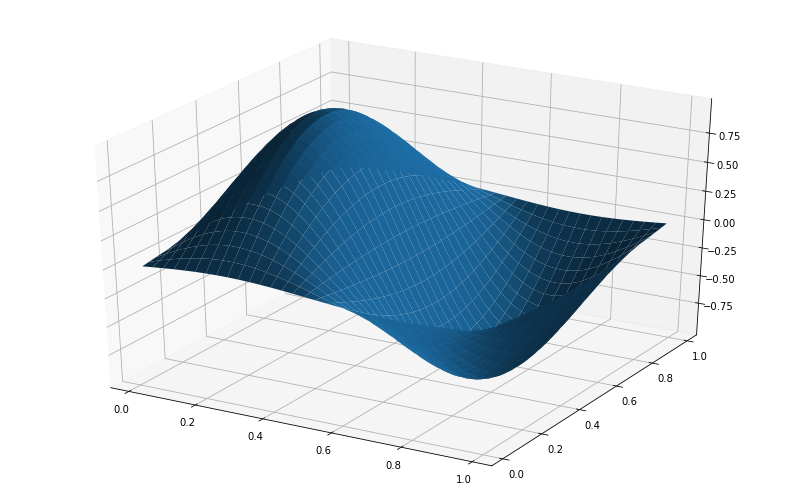

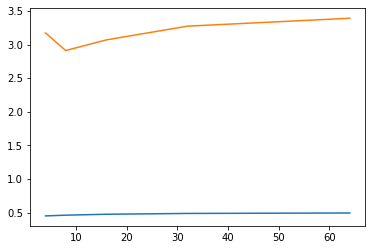

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from scipy import sparse
from scipy.sparse import linalg
from scipy import integrate



# implement A in csr format to maximize speed of spsolve

def A_matrix(n: int):
    I = scipy.sparse.eye(n-1, format = "csr")
    Iup = scipy.sparse.eye(n-1, k = -1, format = "csr")
    Idown = scipy.sparse.eye(n-1, k = 1, format = "csr")
    S = I + Iup + Idown
    T = I * 8 - Iup - Idown
    
    A = 3 * n * (scipy.sparse.kron(I, T, format = "csr") + scipy.sparse.kron((I - S), S, format = "csr"))
    
    return A


print(A_matrix(4).toarray())


#seems to work!

#Now comes M

def M_matrix(n: int):
    I = scipy.sparse.eye(n-1, format = "csr")
    Iup = scipy.sparse.eye(n-1, k = -1, format = "csr")
    Idown = scipy.sparse.eye(n-1, k = 1, format = "csr")
    
    Q = Iup + 4 * I + Idown
    M = 1/n * (scipy.sparse.kron(Q, (0.25 * Q), format = "csr"))
    
    return M 


print(M_matrix(4).toarray())

def b_vector(n: int):
    
    f_store = np.zeros((n-1,n-1))
    
    for  i in range((n-1)):
                       
        for j in range((n-1)):
            f_store[i,j] = 5 * np.pi * np.pi * np.sin(2 * np.pi * (i+1)/n) * np.sin(np.pi * (j+1)/n)
            
    f = np.concatenate(f_store)
    
    return f
    


#This function can be used to approx the solution for desired n, I will only do 64, because its trivial how to do the others, just insert right n 

def solve(n: int):
    
    b = M_matrix(n) @ b_vector(n)
    sol = scipy.sparse.linalg.spsolve(A_matrix(n), b, permc_spec=None, use_umfpack=True)
    return sol

#now calculating and plotting for n = 64, thank you for the comment on the plot from last sheet. I did not know that the arrays x,y had to be 2dim

sol4 = np.reshape(solve(4), (3,3))
sol8 = np.reshape(solve(8), (7,7))
sol16 = np.reshape(solve(16), (15,15))
sol32 = np.reshape(solve(32), (31,31))
sol64 = np.reshape(solve(64), (63,63))



z = sol64

x = np.outer(np.arange(1/64, 1, 1/64), np.ones(63))
y = x.copy().T


# Creating figyre 
fig = plt.figure(figsize =(14, 9)) 
ax = plt.axes(projection ='3d') 
  
# Creating plot 
ax.plot_surface(x, y, z) 
  
# show plot 
plt.show() 

#implement hat function first

def phi(t: float, k: int, n: int):
    val = np.nan
    if ((k-1) < n * t <= k):
        val = (1 - k + n * t)
        
    
    elif (k < n * t <= (k + 1)):
        val = (1 + k - n * t)
    else:
        val = 0
        
    return val

#now exercise c




def u_eval(x: float, y: float, U: np.array, i: int, j: int):
    n = U.shape[0] + 1
    U_0 = np.zeros((n,n))
    U_0[0:-1,0:-1] = U[0:n-1,0:n-1]
    
    u = (U_0[i, j] * phi(x, i, n) * phi(y, j, n) + U_0[i + 1, j] * phi(x, i + 1, n) * phi(y, j, n) + 
         U_0[i, j + 1] * phi(x, i, n) * phi(y, j + 1, n) + U_0[i + 1, j + 1] * phi(x, i + 1, n) * phi(y, j + 1, n))
    
    return u 

def grad_u_eval(x: float, y: float, U: np.array, i: int, j: int):
    n = U.shape[0] + 1
    U_0 = np.zeros((n,n))
    U_0[0:-1,0:-1] = U[0:n-1,0:n-1]
    
    grad_u = np.ones(2) * np.nan
    
    grad_u[0] = (U_0[i, j] * (-n) * phi(y, j, n) + U_0[i, j + 1] * (-n) * phi(y, j + 1, n) + 
                 U_0[i + 1, j] * n * phi(y, j, n) + U_0[i + 1, j + 1] * n * phi(y, j + 1, n))
    
    grad_u[1] = (U_0[i, j] * (-n) * phi(x, i, n) + U_0[i, j + 1] * (n) * phi(x, i, n) + 
                 U_0[i + 1, j] * (-n) * phi(x, i + 1, n) + U_0[i + 1, j + 1] * n * phi(x, i + 1, n))
    
    return grad_u




#Now exercise d


#Implement analytic solution, and its gradient
def u_analytic(x: float, y: float):
    z = np.sin(2 * np.pi * x) * np.sin(np.pi * y)
    return z 

def grad_u_analytic(x: float, y:float):
    z = np.zeros(2) * np.nan
    z[0] = np.cos(2 * np.pi * x) * 2 * np.pi * np.sin(np.pi * y)
    z[1] = np.sin(2 * np.pi * x) * np.cos(np.pi * y) * np.pi
    return z


#Implement the two integrands as python functions
def integrand1(x: float, y: float, U: np.array, i: int, j: int):
    z = u_eval(x, y, U, i, j) - u_analytic(x, y)
    return (z*z)

def integrand2(x: float, y: float, U: np.array, i: int, j: int):
    z = np.zeros(2) * np.nan
    z[0] = grad_u_eval(x, y, U, i, j)[0] - grad_u_analytic(x, y)[0]
    z[1] = grad_u_eval(x, y, U, i, j)[1] - grad_u_analytic(x, y)[1]
    return (z[0]**2 + z[1]**2)


def  error_computation(U: np.array):
    er = np.zeros(2)
    n = U.shape[0] + 1
    for i in range(n - 1):
        for j in range(n - 1):
            
            er[0] = er[0] + integrate.dblquad(integrand1, i/n, (i+1)/n, lambda x: j/n, lambda x: (j+1)/n, args=(U, i, j))[0]
            
            er[1] = er[1] + integrate.dblquad(integrand2, i/n, (i+1)/n, lambda x: j/n, lambda x: (j+1)/n, args=(U, i, j))[0]
            
            
    er[0] = np.sqrt(er[0])
    er[1] = np.sqrt(er[1])
    
    return er

#Exercise e


h = [4, 8, 16, 32, 64]




errorL_2 = [error_computation(sol4)[0], error_computation(sol8)[0], error_computation(sol16)[0], error_computation(sol32)[0], error_computation(sol64)[0]]

errorH_1 = [error_computation(sol4)[1], error_computation(sol8)[1], error_computation(sol16)[1], error_computation(sol32)[1], error_computation(sol64)[1]]

'error Plots'

plt.plot(h, errorL_2)

plt.plot(h, errorH_1)
    












                 



















